In [1]:
%matplotlib inline

# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs and inputs 
try:
    Out.clear() 
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()

import importlib
from libs import params, feats, strats, opts, models_core
importlib.reload(params)
importlib.reload(feats)
importlib.reload(strats)
importlib.reload(opts)
importlib.reload(models_core)

<module 'libs.models_core' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_core.py'>

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import glob
import os
import json
import re
import psutil
import math
from re import findall

import time
from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime
from datetime import time

import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models_core.DayWindowDataset])

# from tqdm.auto import tqdm
from tqdm import tqdm
import json
from PIL import Image
import IPython.display as disp
from IPython.display import clear_output, display

# Turn off interactive plotting globally (we’ll manage our own display)
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import seaborn as sns
from pprint import pprint

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.storages import RDBStorage
from optuna.samplers import TPESampler

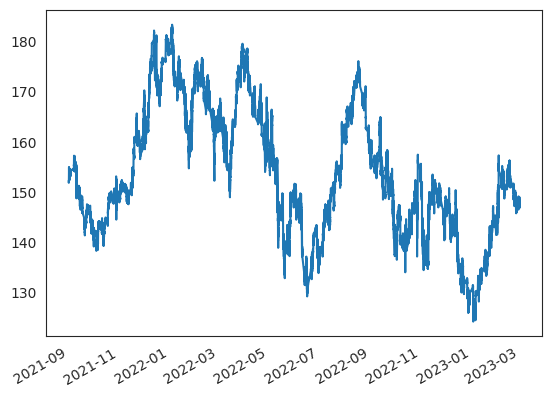

,open,high,low,close,volume,trade_count,vwap,ask,bid,ret,log_ret,sma_5,sma_pct_5,sma_9,sma_pct_9,sma_21,sma_pct_21,sma_50,sma_pct_50,sma_100,sma_pct_100,sma_200,sma_pct_200,ema_3,ema_5,ema_8,ema_9,ema_13,ema_21,ema_50,roc_5,roc_10,roc_21,body,body_pct,upper_shad,lower_shad,range_pct,rsi_6,rsi_14,rsi_21,macd_line_6_13_5,macd_signal_6_13_5,macd_diff_6_13_5,macd_line_12_26_9,macd_signal_12_26_9,macd_diff_12_26_9,atr_7,atr_pct_7,atr_14,atr_pct_14,atr_28,atr_pct_28,plus_di_7,minus_di_7,adx_7,plus_di_14,minus_di_14,adx_14,plus_di_28,minus_di_28,adx_28,bb_lband_20_2p0,bb_hband_20_2p0,bb_w_20_2p0,bb_lband_20_3p0,bb_hband_20_3p0,bb_w_20_3p0,bb_lband_50_2p0,bb_hband_50_2p0,bb_w_50_2p0,obv,vol_spike_7,vol_spike_14,vol_spike_28,rolling_max_close_200,rolling_min_close_200,dist_high_200,dist_low_200,obv_diff_7,obv_pct_7,obv_diff_21,obv_pct_21,ret_std_21,ret_std_63,stoch_k_14_3_3,stoch_d_14_3_3,stoch_k_9_3_3,stoch_d_9_3_3,cci_14,cci_20,mfi_14,mfi_20,cmf_14,cmf_20,donch_h_20,donch_l_20,donch_w_20,donch_h_55,donch_l_55,donch_w_55,roll_vwap_20,roll_vwap_50,slope_close_20,slope_close_50,kc_mid_20_20_1.5,kc_l_20_20_1.5,kc_h_20_20_1.5,kc_w_20_20_1.5,kc_mid_20_20_2.0,kc_l_20_20_2.0,kc_h_20_20_2.0,kc_w_20_20_2.0,psar,vwap_ohlc_close_session
2021-09-01 08:00:00,152.340,152.400,152.200,152.310,2052.0,79.0,152.343289,152.3405,152.2795,0.002633,0.002630,151.956,0.002330,151.911111,0.002626,151.874286,0.002869,151.8499,0.003030,151.862701,0.002945,151.874676,0.002866,152.096413,152.018578,151.964327,151.953148,151.923549,151.894996,151.867887,0.002963,0.003095,0.003161,-0.03,-0.000197,0.06,0.11,0.001313,97.117392,92.108647,88.907688,0.072060,0.027698,0.044362,0.043925,0.012360,0.031565,0.093550,0.000614,0.053679,0.000352,0.031763,0.000209,84.467536,3.401602,28.421520,77.491111,7.239535,19.072892,69.968105,11.638923,14.391505,151.674268,152.077732,0.002657,151.573401,152.178599,0.003985,151.714905,151.984895,0.001778,1.529217e+10,0.613270,1.023843,1.224605,152.40,151.80,0.000591,0.003348,19082.0,125.599677,27680.000000,182.256001,0.000579,0.000339,0.948276,0.871648,0.948276,0.816092,466.666667,500.000000,85.708219,81.744827,0.262026,0.233686,152.400000,151.82,0.003808,152.400,151.80,0.003939,151.889248,151.866828,0.007699,0.001677,151.897444,151.836322,151.958567,0.000805,151.897444,151.815948,151.978941,0.001073,151.820000,152.310000
2021-09-01 08:01:00,152.310,152.310,152.310,152.310,1163.0,12.0,152.310000,152.3405,152.2795,0.000000,0.000000,152.048,0.001723,151.961111,0.002296,151.896667,0.002721,151.8593,0.002968,151.866702,0.002919,151.876876,0.002852,152.203206,152.115719,152.041143,152.024518,151.978756,151.932724,151.885225,0.003029,0.003095,0.003095,0.00,0.000000,0.00,0.00,0.000000,97.117392,92.108647,88.907688,0.106679,0.054025,0.052654,0.071035,0.024095,0.046941,0.080186,0.000526,0.049844,0.000327,0.030628,0.000201,84.467536,3.401602,37.540956,77.491111,7.239535,23.632803,69.968105,11.638923,16.430226,151.624973,152.175027,0.003621,151.487459,152.312541,0.005432,151.672758,152.045842,0.002457,1.529217e+10,0.376288,0.576864,0.696184,152.40,151.80,0.000591,0.003348,17295.0,113.788242,26841.000000,176.705655,0.000579,0.000339,0.896552,0.911239,0.896552,0.892720,235.338654,336.051648,85.801987,86.061612,0.295809,0.278437,152.400000,151.82,0.003808,152.400,151.80,0.003939,151.905092,151.875656,0.013173,0.002735,151.936735,151.878669,151.994802,0.000764,151.936735,151.859314,152.014157,0.001019,151.820000,152.310000
2021-09-01 08:02:00,152.300,152.300,152.300,152.300,900.0,32.5,152.300000,152.3305,152.2695,-0.000066,-0.000066,152.138,0.001065,152.011111,0.001900,151.919048,0.002508,151.8687,0.002840,151.870602,0.002827,151.879026,0.002772,152.251603,152.177146,152.098667,152.079614,152.024648,151.966113,151.901491,0.002963,0.002897,0.003096,0.00,0.000000,0.00,0.00,0.000000,94.266696,90.188784,87.281932,0.122091,0.076714,0.045377,0.090669,0.037410,0.053259,0.070159,0.000461,0.046998,0.000309,0.029892,0.000196,82.747626,5.368519,44.722948,76.313395,8.6

In [3]:
## INDICATORS STRATEGIES DF ##

df_inds = pd.read_csv(params.indunsc_csv, index_col=0, parse_dates=True) ############### 
df_inds = df_inds[(df_inds.index >= '2021-09-01') & (df_inds.index < '2023-03-01')] #########################

df_inds.close.plot()
plt.show()
df_inds

In [4]:
##### 95 ######
# {'reset_peak': (0, 0),
#  'rsi_min_thresh': (43, 47),
#  'rsi_max_thresh': (49, 51),
#  'adx_thresh': (54.182016788650685, 54.99579321134931),
#  'atr_mult': (16.694410274720497, 18.336149725279498),
#  'vwap_atr_mult': (-0.21776640620967802, 0.617386406209678),
#  'buy_factor': (0.7414908137030546, 0.8158391862969453),
#  'sell_factor': (0.03504106095237648, 0.05612893904762352),
#  'trailstop_pct': (18.313730235902057, 30.31062976409794),
#  'sign_thresh_pair': {'categorical': ['ema_3|ema_8']}}

##### 97 ######
# {'reset_peak': (0, 0),
#  'rsi_min_thresh': (27, 35),
#  'rsi_max_thresh': (50, 50),
#  'adx_thresh': (54.48213536933162, 54.65967463066837),
#  'atr_mult': (16.551936093816696, 18.439403906183305),
#  'vwap_atr_mult': (0.6030502094385315, 1.0297097905614685),
#  'buy_factor': (0.7726095987344072, 0.8673004012655928),
#  'sell_factor': (0.032442553605695895, 0.0424274463943041),
#  'trailstop_pct': (19.127797192673505, 32.404702807326494),
#  'sign_thresh_pair': {'categorical': ['ema_3|ema_8']}}

In [5]:
# Pre-compute per-day slices once
groups = df_inds.groupby(df_inds.index.normalize())
prun_perc = 80 # higher value means the pruner keeps more trials (e.g., 90 keeps the top 10%)
report_interval = 50
_findall = re.compile(r"[+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?").findall

def objective(trial: optuna.Trial) -> float:
    reset_peak       = trial.suggest_categorical("reset_peak", [False])
    rsi_min_thresh   = trial.suggest_int("rsi_min_thresh", 26, 38)
    rsi_max_thresh   = trial.suggest_int("rsi_max_thresh", max(rsi_min_thresh + 1, 48), 52)
    adx_thresh       = trial.suggest_float("adx_thresh", 54.0, 55.0)
    atr_mult         = trial.suggest_float("atr_mult", 16.5, 18.5, log=True)
    vwap_atr_mult    = trial.suggest_float("vwap_atr_mult", 0, 1)
    buy_factor       = trial.suggest_float("buy_factor", 0.7, 0.85)
    sell_factor      = trial.suggest_float("sell_factor", 0.03, 0.05)
    trailstop_pct    = trial.suggest_float("trailstop_pct", 18.0, 32.0)
    sign_thresh_pair = trial.suggest_categorical("sign_thresh_pair",[ 
                                                    "ema_3|ema_8",
                                                    # "ema_5|ema_13",
                                                    # "ema_9|ema_21",
                                                    # "ema_21|ema_50",
                                                    # "roc_5|ema_21"
                                                    # "roc_5|0.0"
                                                    # "macd_line_12_26_9|0.0"
                                                    # "macd_diff_6_13_5|0.0"
                                                    # "rsi_14|50.0"
                                                    # "rsi_6|50.0"
                                                ])
    col_signal, sign_thresh = sign_thresh_pair.split("|")
    try: 
        sign_thresh = float(sign_thresh) # convert numeric thresholds (only if it´s numeric)
    except ValueError:
        pass # the threshold is a signal
    
    print('-' * 160)
    print("Params => " + "; ".join(f"{k}={v}" for k, v in dict(trial.params).items()))

    start_ask = df_inds.loc[df_inds.index.normalize() == df_inds.index.normalize().min(), "ask"].iat[0]
    strats.reset_globals(start_ask)  # necessary to correctly reset the global variables before each independent simulation
    
    daily_pnls: List[float] = []
    daily_bh_pnls: List[float] = []
    trades_count = 0
    holds_count = 0 
    total_bars = 0
    pbar = tqdm(groups, desc=f"Trial {trial.number}", leave=True)

    trial_action_counts = {"Buy": 0, "Sell": 0, "Hold": 0}
    
    for step, (day, df_day) in enumerate(pbar, 1):

        df_actions = strats.generate_actions_alpaca(
            df              = df_day,
            col_atr         = params.col_atr_tick,
            col_adx         = params.col_adx_tick,
            col_rsi         = params.col_rsi_tick,
            col_vwap        = params.col_vwap_tick,
            col_signal      = col_signal,
            sign_thresh     = sign_thresh,
            reset_peak      = reset_peak,
            rsi_min_thresh  = rsi_min_thresh,
            rsi_max_thresh  = rsi_max_thresh,
            adx_thresh      = adx_thresh,
            atr_mult        = atr_mult,
            vwap_atr_mult   = vwap_atr_mult,
            trailstop_pct   = trailstop_pct,
        )

        sim_results = strats.simulate_trading(
            day             = day,
            df              = df_actions,
            buy_factor      = buy_factor,
            sell_factor     = sell_factor,
        )
   
        df_sim, trades, stats = next(iter(sim_results.values()))

        # accumulate executed Action counts from df_sim
        trial_action_counts["Buy"] += int((df_sim["Action"] == "Buy").sum())
        trial_action_counts["Sell"] += int((df_sim["Action"] == "Sell").sum())
        trial_action_counts["Hold"] += int((df_sim["Action"] == "Hold").sum())

        trades_count += len(trades)
        holds_count += int((df_sim["Action"] == "Hold").sum())
        total_bars += len(df_sim)

        daily_pnls.append(strats._parse_eq_value(stats['STRATEGY']))
        daily_bh_pnls.append(strats._parse_eq_value(stats['BUYNHOLD']))

        # Explicitly delete large locals at the end of each iteration
        del df_actions, sim_results, stats
        df_day = df_actions = sim_results = stats = None

        if step % report_interval == 0:
            report_step = step // report_interval
            prun_val = np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls))
            
            # sets partial set_user_attr (just to be available if trial pruned)
            trial.set_user_attr("mean_pnl", float(np.mean(daily_pnls)))
            trial.set_user_attr("mean_bh_pnls", float(np.mean(daily_bh_pnls)))
            trial.set_user_attr("action_counts", {k: int(v) for k, v in trial_action_counts.items()})
            
            trial.report(float(prun_val), report_step)
            if trial.should_prune():
                vals = [t.intermediate_values[report_step]
                        for t in trial.study.get_trials(deepcopy=False)
                        if t.state == TrialState.COMPLETE and report_step in t.intermediate_values]
                thr = np.percentile(vals, prun_perc)
                print(f"[PRUNE] value={prun_val:.6f} thr={thr:.6f}")
                pbar.close()
                raise optuna.TrialPruned()

    # sets final set_user_attr
    trial.set_user_attr("mean_pnl", float(np.mean(daily_pnls)))
    trial.set_user_attr("mean_bh_pnls", float(np.mean(daily_bh_pnls)))
    trial.set_user_attr("action_counts", {k: int(v) for k, v in trial_action_counts.items()})
    
    mean_excess = np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls))
    return float(mean_excess)


Baseline mean daily B&H: -9.5162


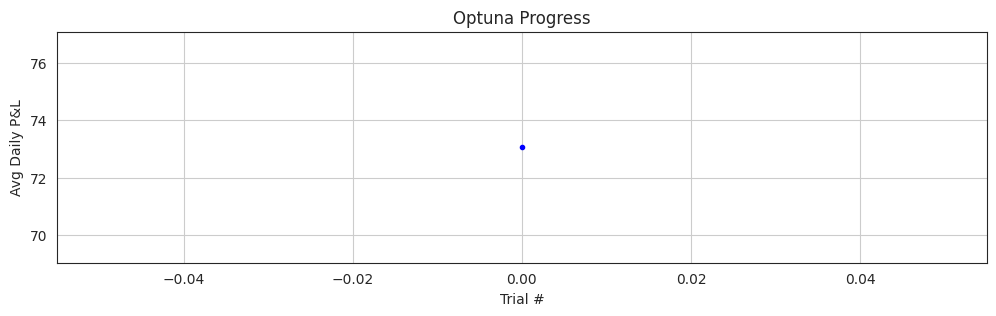

----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=51; adx_thresh=54.46034420375542; atr_mult=18.393316928468263; vwap_atr_mult=0.035369959631080694; buy_factor=0.7008793510333894; sell_factor=0.045631610069009815; trailstop_pct=26.79507261125593; sign_thresh_pair=ema_3|ema_8


Trial 0: 100%|██████████| 375/375 [02:54<00:00,  2.15it/s]


[Results] mean_pnl:64.3140 mean_bh:-8.7491 mean_excess:73.0631 improv_vs_bh:835.09%
Action counts: {'Buy': 1089, 'Sell': 15605, 'Hold': 334017}
Best trial is: 0 with best_val: 73.0631
[save_results] wrote optuna_results/AAPL_73.0631_predicted.csv
[save_best_json] wrote optuna_results/AAPL_73.0631_predicted.json
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=48; adx_thresh=54.804642209364424; atr_mult=17.727475709566153; vwap_atr_mult=0.6951992000826892; buy_factor=0.8470451472764279; sell_factor=0.04047630798980779; trailstop_pct=18.65843603494694; sign_thresh_pair=ema_3|ema_8


Trial 1:  92%|█████████▏| 345/375 [01:51<00:06,  4.76it/s]

In [ ]:
# importlib.reload(strats)
# importlib.reload(params)

start = df_inds.loc[df_inds.index.normalize() == df_inds.index.normalize().min(), "ask"].iat[0]
end   = df_inds.loc[df_inds.index.normalize() == df_inds.index.normalize().max(), "bid"].iat[-1]
baseline_pnl = int(params.init_cash // start) * (end - start) / df_inds.index.normalize().nunique()
print(f"Baseline mean daily B&H: {baseline_pnl:.4f}")

# Create the two display slots just below the baseline output
opts.init_optuna_displays()

optuna.logging.set_verbosity(optuna.logging.ERROR)

n_trials = 7000
trials_before_pruning = 250
trials_of_exploration = 350

reports_per_trial = math.ceil(len(groups) / report_interval)
n_warmup_steps = math.ceil(reports_per_trial * 0.30)

# sampler = TPESampler(n_startup_trials=trials_of_exploration, multivariate=True)

pruner = optuna.pruners.PercentilePruner(
    percentile=prun_perc,
    n_startup_trials=trials_before_pruning,
    n_warmup_steps=n_warmup_steps,
)

study = optuna.create_study(
    pruner=pruner,
    # sampler=sampler,
    direction="maximize",
)

# Per-run callbacks with suffix "predicted"
cb_save_csv  = opts.make_save_results_callback("predicted")
cb_save_json = opts.make_save_best_json_callback("predicted")

study.optimize(
    objective,
    n_trials=n_trials,
    callbacks=[opts.plot_callback, opts.short_log_callback, cb_save_csv, cb_save_json],
    gc_after_trial=True,
)

plt.close("all"); gc.collect()